# Initialize Folders

In [1]:
from __future__ import print_function
from imutils import paths
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import keras

from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as keras
#from keras.layers.advanced_activations import LeakyReLU, PReLU


#import skimage.io as io
#import skimage.transform as trans

#K.set_image_data_format("channels_last")

%matplotlib inline
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
root_dir = './data'
training_data_dir = os.path.join(root_dir, 'train/images')
training_data_mask_dir = os.path.join(root_dir, 'train/masks')

val_data_dir = os.path.join(root_dir, 'val/images')
val_data_pred_dir = os.path.join(root_dir, 'val/predict')
val_data_mask_dir = os.path.join(root_dir, 'val/masks')

test_data_dir = os.path.join(root_dir, 'test/images')
test_data_pred_dir = os.path.join(root_dir, 'test/predict')
test_data_mask_dir = os.path.join(root_dir, 'test/masks')

img_rows = 256
img_cols = 256

# Define Loss function

In [13]:
#Define loss function
def jaccard_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return  (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def jaccard_coef_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    j = -(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    if (j > 0.65):
        j = j - 1
    return j

In [4]:
def normalizeData_rgb(img,mask):
    for i in range(3):
        mean = np.mean(img[:,:,i])  # mean for data centering
        std = np.std(img[:,:,i])  # std for data normalization
        img[:,:,i] -= mean
        img[:,:,i] /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [5]:
def normalizeData(img,mask):
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization
    img -= mean
    img /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [6]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = normalizeData_rgb(img,mask)
        yield (img,mask)

In [7]:
def validationGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = normalizeData_rgb(img,mask)
        yield (img,mask)

# Define UNet Network

In [8]:
def UnetModel():
    inputs = Input((img_rows, img_cols,1))
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])

    return model

In [9]:
def UnetLeakyModel():
    inputs = Input((img_rows, img_cols,3))
    conv1 = Conv2D(32, (3, 3), padding="same")(inputs)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    conv1 = Conv2D(32, (3, 3), padding="same")(acti1)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(acti1)

    conv2 = Conv2D(64, (3, 3), padding="same")(pool1)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    conv2 = Conv2D(64, (3, 3), padding="same")(acti2)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(acti2)

    conv3 = Conv2D(128, (3, 3), padding="same")(pool2)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    conv3 = Conv2D(128, (3, 3), padding="same")(acti3)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(acti3)

    conv4 = Conv2D(256, (3, 3), padding="same")(pool3)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    conv4 = Conv2D(256, (3, 3), padding="same")(acti4)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(acti4)

    conv5 = Conv2D(512, (3, 3), padding="same")(pool4)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    conv5 = Conv2D(512, (3, 3), padding="same")(acti5)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(acti5), acti4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding="same")(up6)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    conv6 = Conv2D(256, (3, 3), padding="same")(acti6)
    acti6 = LeakyReLU(alpha=0.001)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(acti6), acti3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding="same")(up7)
    acti7 = LeakyReLU(alpha=0.001)(conv7)
    conv7 = Conv2D(128, (3, 3), padding="same")(acti7)
    acti7 = LeakyReLU(alpha=0.001)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(acti7), acti2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding="same")(up8)
    acti8 = LeakyReLU(alpha=0.001)(conv8)
    conv8 = Conv2D(64, (3, 3), padding="same")(acti8)
    acti8 = LeakyReLU(alpha=0.001)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(acti8), acti1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding="same")(up9)
    acti9 = LeakyReLU(alpha=0.001)(conv9)
    conv9 = Conv2D(32, (3, 3), padding="same")(acti9)
    acti9 = LeakyReLU(alpha=0.001)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(acti9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=5e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])

    return model

In [10]:
def LeakyUnetModelBig():
    inputs = Input((img_rows, img_cols,1))
    conv1 = Conv2D(32, (3, 3), padding="same")(inputs)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    conv1 = Conv2D(32, (3, 3), padding="same")(acti1)
    acti1 = LeakyReLU(alpha=0.001)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(acti1)

    conv2 = Conv2D(64, (3, 3), padding="same")(pool1)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    conv2 = Conv2D(64, (3, 3), padding="same")(acti2)
    acti2 = LeakyReLU(alpha=0.001)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(acti2)

    conv3 = Conv2D(128, (3, 3), padding="same")(pool2)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    conv3 = Conv2D(128, (3, 3), padding="same")(acti3)
    acti3 = LeakyReLU(alpha=0.001)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(acti3)

    conv4 = Conv2D(256, (3, 3), padding="same")(pool3)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    conv4 = Conv2D(256, (3, 3), padding="same")(acti4)
    acti4 = LeakyReLU(alpha=0.001)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(acti4)

    conv5 = Conv2D(512, (3, 3), padding="same")(pool4)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    conv5 = Conv2D(512, (3, 3), padding="same")(acti5)
    acti5 = LeakyReLU(alpha=0.001)(conv5)
    
    conv6 = Conv2D(512, (3, 3), padding="same")(acti5)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    conv6 = Conv2D(512, (3, 3), padding="same")(acti6)
    acti6 = LeakyReLU(alpha=0.001)(conv6)
    
    right_up1 = concatenate([UpSampling2D(size=(2, 2))(acti6), acti4], axis=3)
    right_conv1 = Conv2D(256, (3, 3), padding="same")(right_up1)
    right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)
    right_conv1 = Conv2D(256, (3, 3), padding="same")(right_acti1)
    right_acti1 = LeakyReLU(alpha=0.001)(right_conv1)

    right_up2 = concatenate([UpSampling2D(size=(2, 2))(right_acti1), acti3], axis=3)
    right_conv2 = Conv2D(128, (3, 3), padding="same")(right_up2)
    right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)
    right_conv2 = Conv2D(128, (3, 3), padding="same")(right_acti2)
    right_acti2 = LeakyReLU(alpha=0.001)(right_conv2)

    right_up3 = concatenate([UpSampling2D(size=(2, 2))(right_acti2), acti2], axis=3)
    right_conv3 = Conv2D(64, (3, 3), padding="same")(right_up3)
    right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)
    right_conv3 = Conv2D(64, (3, 3), padding="same")(right_acti3)
    right_acti3 = LeakyReLU(alpha=0.001)(right_conv3)

    right_up4 = concatenate([UpSampling2D(size=(2, 2))(right_conv3), acti1], axis=3)
    right_conv4 = Conv2D(32, (3, 3), padding="same")(right_up4)
    right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)
    right_conv4 = Conv2D(32, (3, 3), padding="same")(right_acti4)
    right_acti4 = LeakyReLU(alpha=0.001)(right_conv4)

    output = Conv2D(1, (1, 1), activation='sigmoid')(right_acti4)

    model = Model(input=inputs, output=output)

    model.compile(optimizer=Adam(lr=3e-5), loss=jaccard_coef_loss, metrics=[jaccard_coef])

    return model

In [11]:
def FullUnetModel():
    inputs = Input((img_rows, img_cols,1))
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(pool4)
    conv5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation="relu", padding="same")(up8)
    conv8 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation="relu", padding="same")(up9)
    conv9 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss=jaccard_coef_loss, metrics=[jaccard_coef])

    return model

In [14]:
#Training data generation
data_gen_args = dict(
#    samplewise_center = True,
#    samplewise_std_normalization = True,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest')

#Validation data generation
data_val_gen_args = dict(
    #samplewise_center = True,
    #samplewise_std_normalization = True
    )

#Create UNet Model
#model = FullUnetModel()
#model = UnetModel()
model = UnetLeakyModel()

C:\Users\li_ni\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [71]:
#Setup generator
batch_size = 3

myGene = trainGenerator(batch_size,'data/train','images','masks',data_gen_args)
myValGene = validationGenerator(batch_size,'data/val','images','masks',data_val_gen_args)

#Setup Checkpoint to only capture best estimate
model_checkpoint = ModelCheckpoint('unet_lesion.hdf5', monitor='loss',verbose=1, save_best_only=True)

#Enable tensorboard
tensorBoard = TensorBoard(
    log_dir='./logs', 
    histogram_freq=0, 
    batch_size=batch_size, 
    write_graph=True, 
    write_grads=False, 
    write_images=True, 
    embeddings_freq=0)


In [72]:

#Train
history = model.fit_generator(
    myGene,
    steps_per_epoch = 600, 
    epochs=200,
    callbacks=[model_checkpoint,tensorBoard],
    validation_data=myValGene,
    validation_steps=200)

Epoch 1/200
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
Found 519 images belonging to 1 classes.
Found 1555 images belonging to 1 classes.
600/600 [==============================] - 580s 967ms/step - loss: -0.5096 - jaccard_coef: 0.5096 - val_loss: -0.6585 - val_jaccard_coef: 0.6585

Epoch 00001: loss improved from inf to -0.50956, saving model to unet_lesion.hdf5
Epoch 2/200
600/600 [==============================] - 564s 940ms/step - loss: -0.6369 - jaccard_coef: 0.6369 - val_loss: -0.7029 - val_jaccard_coef: 0.7029

Epoch 00002: loss improved from -0.50956 to -0.63674, saving model to unet_lesion.hdf5
Epoch 3/200
600/600 [==============================] - 563s 939ms/step - loss: -0.6608 - jaccard_coef: 0.6608 - val_loss: -0.7091 - val_jaccard_coef: 0.7091

Epoch 00003: loss improved from -0.63674 to -0.66082, saving model to unet_lesion.hdf5
Epoch 4/200
600/600 [==============================] - 559s 932ms/step - loss: -0.6874 - jaccard_coef: 0

600/600 [==============================] - 571s 952ms/step - loss: -0.7685 - jaccard_coef: 0.7685 - val_loss: -0.7709 - val_jaccard_coef: 0.7709

Epoch 00036: loss did not improve from -0.76970
Epoch 37/200
600/600 [==============================] - 585s 976ms/step - loss: -0.7609 - jaccard_coef: 0.7609 - val_loss: -0.7612 - val_jaccard_coef: 0.7612

Epoch 00037: loss did not improve from -0.76970
Epoch 38/200
600/600 [==============================] - 581s 969ms/step - loss: -0.7660 - jaccard_coef: 0.7660 - val_loss: -0.7747 - val_jaccard_coef: 0.7747

Epoch 00038: loss did not improve from -0.76970
Epoch 39/200
600/600 [==============================] - 580s 967ms/step - loss: -0.7645 - jaccard_coef: 0.7645 - val_loss: -0.7830 - val_jaccard_coef: 0.7830

Epoch 00039: loss did not improve from -0.76970
Epoch 40/200
600/600 [==============================] - 576s 959ms/step - loss: -0.7739 - jaccard_coef: 0.7739 - val_loss: -0.7708 - val_jaccard_coef: 0.7708

Epoch 00040: loss improved


Epoch 00074: loss did not improve from -0.78960
Epoch 75/200
600/600 [==============================] - 560s 933ms/step - loss: -0.7876 - jaccard_coef: 0.7876 - val_loss: -0.7941 - val_jaccard_coef: 0.7941

Epoch 00075: loss did not improve from -0.78960
Epoch 76/200
600/600 [==============================] - 564s 940ms/step - loss: -0.7877 - jaccard_coef: 0.7877 - val_loss: -0.7889 - val_jaccard_coef: 0.7889

Epoch 00076: loss did not improve from -0.78960
Epoch 77/200
600/600 [==============================] - 568s 947ms/step - loss: -0.7775 - jaccard_coef: 0.7775 - val_loss: -0.7764 - val_jaccard_coef: 0.7764

Epoch 00077: loss did not improve from -0.78960
Epoch 78/200
600/600 [==============================] - 569s 948ms/step - loss: -0.7893 - jaccard_coef: 0.7893 - val_loss: -0.7889 - val_jaccard_coef: 0.7889

Epoch 00078: loss did not improve from -0.78960
Epoch 79/200
600/600 [==============================] - 560s 934ms/step - loss: -0.7871 - jaccard_coef: 0.7871 - val_loss: 


Epoch 00113: loss did not improve from -0.80227
Epoch 114/200
600/600 [==============================] - 579s 965ms/step - loss: -0.8030 - jaccard_coef: 0.8030 - val_loss: -0.7896 - val_jaccard_coef: 0.7896

Epoch 00114: loss improved from -0.80227 to -0.80298, saving model to unet_lesion.hdf5
Epoch 115/200
600/600 [==============================] - 569s 949ms/step - loss: -0.8001 - jaccard_coef: 0.8001 - val_loss: -0.7580 - val_jaccard_coef: 0.7580

Epoch 00115: loss did not improve from -0.80298
Epoch 116/200
600/600 [==============================] - 558s 930ms/step - loss: -0.8015 - jaccard_coef: 0.8015 - val_loss: -0.7859 - val_jaccard_coef: 0.7859

Epoch 00116: loss did not improve from -0.80298
Epoch 117/200
600/600 [==============================] - 582s 969ms/step - loss: -0.7996 - jaccard_coef: 0.7996 - val_loss: -0.7866 - val_jaccard_coef: 0.7866

Epoch 00117: loss did not improve from -0.80298
Epoch 118/200
600/600 [==============================] - 559s 931ms/step - loss:

600/600 [==============================] - 604s 1s/step - loss: -0.8104 - jaccard_coef: 0.8104 - val_loss: -0.7933 - val_jaccard_coef: 0.7933

Epoch 00152: loss did not improve from -0.81695
Epoch 153/200
600/600 [==============================] - 603s 1s/step - loss: -0.8133 - jaccard_coef: 0.8133 - val_loss: -0.7891 - val_jaccard_coef: 0.7891

Epoch 00153: loss did not improve from -0.81695
Epoch 154/200
600/600 [==============================] - 615s 1s/step - loss: -0.8179 - jaccard_coef: 0.8179 - val_loss: -0.7908 - val_jaccard_coef: 0.7908

Epoch 00154: loss improved from -0.81695 to -0.81779, saving model to unet_lesion.hdf5
Epoch 155/200
600/600 [==============================] - 604s 1s/step - loss: -0.8094 - jaccard_coef: 0.8094 - val_loss: -0.7885 - val_jaccard_coef: 0.7885

Epoch 00155: loss did not improve from -0.81779
Epoch 156/200
600/600 [==============================] - 597s 994ms/step - loss: -0.8060 - jaccard_coef: 0.8060 - val_loss: -0.8042 - val_jaccard_coef: 0.8

Epoch 191/200
600/600 [==============================] - 560s 934ms/step - loss: -0.8250 - jaccard_coef: 0.8250 - val_loss: -0.7924 - val_jaccard_coef: 0.7924

Epoch 00191: loss improved from -0.82332 to -0.82534, saving model to unet_lesion.hdf5
Epoch 192/200
600/600 [==============================] - 572s 953ms/step - loss: -0.8200 - jaccard_coef: 0.8200 - val_loss: -0.7960 - val_jaccard_coef: 0.7960

Epoch 00192: loss did not improve from -0.82534
Epoch 193/200
600/600 [==============================] - 558s 929ms/step - loss: -0.8190 - jaccard_coef: 0.8190 - val_loss: -0.8089 - val_jaccard_coef: 0.8089

Epoch 00193: loss did not improve from -0.82534
Epoch 194/200
600/600 [==============================] - 582s 970ms/step - loss: -0.8221 - jaccard_coef: 0.8221 - val_loss: -0.7824 - val_jaccard_coef: 0.7824

Epoch 00194: loss did not improve from -0.82534
Epoch 195/200
600/600 [==============================] - 571s 952ms/step - loss: -0.8264 - jaccard_coef: 0.8264 - val_loss: -0.79

In [26]:
#Continue traing
#Use initial_epoch 

history2 = model.fit_generator(
    myGene,
    steps_per_epoch = 1000, 
    epochs=200,
    callbacks=[model_checkpoint,tensorBoard], 
    initial_epoch = 125,
    validation_data=myValGene,
    validation_steps=200)

Epoch 126/200
1000/1000 [==============================] - 911s 911ms/step - loss: -0.7609 - jaccard_coef: 0.7609 - val_loss: -0.7301 - val_jaccard_coef: 0.7301

Epoch 00126: loss improved from inf to -0.76097, saving model to unet_lesion.hdf5
Epoch 127/200
1000/1000 [==============================] - 891s 891ms/step - loss: -0.7529 - jaccard_coef: 0.7529 - val_loss: -0.7368 - val_jaccard_coef: 0.7368

Epoch 00127: loss did not improve from -0.76097
Epoch 128/200
1000/1000 [==============================] - 887s 887ms/step - loss: -0.7641 - jaccard_coef: 0.7641 - val_loss: -0.7383 - val_jaccard_coef: 0.7383

Epoch 00128: loss improved from -0.76097 to -0.76421, saving model to unet_lesion.hdf5
Epoch 129/200
1000/1000 [==============================] - 897s 897ms/step - loss: -0.7578 - jaccard_coef: 0.7578 - val_loss: -0.7526 - val_jaccard_coef: 0.7526

Epoch 00129: loss did not improve from -0.76421
Epoch 130/200
1000/1000 [==============================] - 878s 878ms/step - loss: -0.7

Epoch 163/200
1000/1000 [==============================] - 891s 891ms/step - loss: -0.7936 - jaccard_coef: 0.7936 - val_loss: -0.7959 - val_jaccard_coef: 0.7959

Epoch 00163: loss did not improve from -0.80192
Epoch 164/200
1000/1000 [==============================] - 880s 880ms/step - loss: -0.8051 - jaccard_coef: 0.8051 - val_loss: -0.7824 - val_jaccard_coef: 0.7824

Epoch 00164: loss improved from -0.80192 to -0.80505, saving model to unet_lesion.hdf5
Epoch 165/200
1000/1000 [==============================] - 890s 890ms/step - loss: -0.7959 - jaccard_coef: 0.7959 - val_loss: -0.7929 - val_jaccard_coef: 0.7929

Epoch 00165: loss did not improve from -0.80505
Epoch 166/200
1000/1000 [==============================] - 892s 892ms/step - loss: -0.8013 - jaccard_coef: 0.8013 - val_loss: -0.7862 - val_jaccard_coef: 0.7862

Epoch 00166: loss did not improve from -0.80505
Epoch 167/200
1000/1000 [==============================] - 888s 888ms/step - loss: -0.8042 - jaccard_coef: 0.8042 - val_l


Epoch 00200: loss improved from -0.81610 to -0.81969, saving model to unet_lesion.hdf5


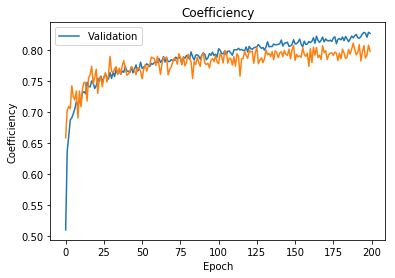

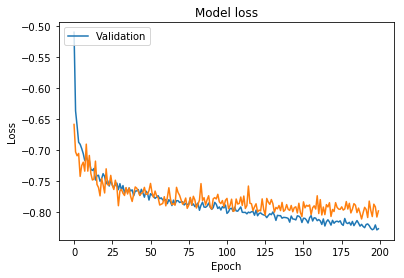

In [73]:
# Plot training & validation accuracy values
plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['val_jaccard_coef'])
plt.title('Coefficiency')
plt.ylabel('Coefficiency')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Validation'], loc='upper left')
plt.show()

In [29]:
file_names = next(os.walk(test_data_dir))[2]

model = LeakyUnetModelBig()
model.load_weights("unet_lesion.hdf5")

C:\Users\li_ni\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [19]:
help(model)

Help on Model in module keras.engine.training object:

class Model(keras.engine.network.Network)
 |  Model(*args, **kwargs)
 |  
 |  The `Model` class adds training & evaluation routines to a `Network`.
 |  
 |  Method resolution order:
 |      Model
 |      keras.engine.network.Network
 |      keras.engine.base_layer.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compile(self, optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs)
 |      Configures the model for training.
 |      
 |      # Arguments
 |          optimizer: String (name of optimizer) or optimizer instance.
 |              See [optimizers](/optimizers).
 |          loss: String (name of objective function) or objective function.
 |              See [losses](/losses).
 |              If the model has multiple outputs, you can use a different loss
 |              on each output by passing a dictionary or a list of losses

In [51]:
file_names = next(os.walk(test_data_dir))[2]

model = UnetModel()
model.load_weights("unet_lesion.hdf5")


for file in file_names:
    print(file)
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=True)
    img = img_to_array(grey_img)
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization
    img -= mean
    img /= std
    img = np.reshape(img,(1,)+img.shape)
    results = model.predict(img)

    result_img = array_to_img(results[0] * 255 )
    #plt.imshow(result_img)
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

C:\Users\li_ni\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


ISIC_0000034.jpg


C:\Users\li_ni\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


ISIC_0000054.jpg
ISIC_0000058.jpg
ISIC_0000060.jpg
ISIC_0000064.jpg
ISIC_0000079.jpg
ISIC_0000081.jpg
ISIC_0000112.jpg
ISIC_0000117.jpg
ISIC_0000128.jpg
ISIC_0000137.jpg
ISIC_0000172.jpg
ISIC_0000184.jpg
ISIC_0000207.jpg
ISIC_0000219.jpg
ISIC_0000222.jpg
ISIC_0000224.jpg
ISIC_0000228.jpg
ISIC_0000262.jpg
ISIC_0000269.jpg
ISIC_0000274.jpg
ISIC_0000277.jpg
ISIC_0000279.jpg
ISIC_0000299.jpg
ISIC_0000310.jpg
ISIC_0000331.jpg
ISIC_0000336.jpg
ISIC_0000349.jpg
ISIC_0000350.jpg
ISIC_0000357.jpg
ISIC_0000361.jpg
ISIC_0000363.jpg
ISIC_0000376.jpg
ISIC_0000383.jpg
ISIC_0000425.jpg
ISIC_0000426.jpg
ISIC_0000470.jpg
ISIC_0000479.jpg
ISIC_0000482.jpg
ISIC_0000487.jpg
ISIC_0000490.jpg
ISIC_0000513.jpg
ISIC_0000519.jpg
ISIC_0000520.jpg
ISIC_0000900.jpg
ISIC_0001103.jpg
ISIC_0001163.jpg
ISIC_0001385.jpg
ISIC_0002093.jpg
ISIC_0002353.jpg
ISIC_0002780.jpg
ISIC_0002871.jpg
ISIC_0003005.jpg
ISIC_0006114.jpg
ISIC_0006350.jpg
ISIC_0006711.jpg
ISIC_0006776.jpg
ISIC_0007156.jpg
ISIC_0007788.jpg
ISIC_0007796.j

In [131]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 32, 256, 256) 320         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 32, 256, 256) 9248        conv2d_189[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 32, 128, 128) 0           conv2d_190[0][0]                 
__________________________________________________________________________________________________
conv2d_191

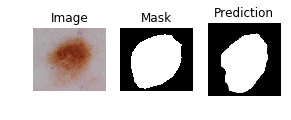

In [130]:
file_names = next(os.walk(test_data_dir))[2]
image = file_names[0]
fig = plt.figure()

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(load_img(os.path.join(test_data_dir,image)), shape = (256,256))
a.set_title('Image')
a.set_axis_off()

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(load_img(os.path.join(test_data_mask_dir,image.split('.')[0]+"_segmentation.png")), shape = (256,256))
a.set_title('Mask')
a.set_axis_off()

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(load_img(os.path.join(test_data_pred_dir,image.split('.')[0]+"_predict.jpg")), shape = (256,256))
a.set_title('Prediction')
a.set_axis_off()

In [ ]:
african_e66lephant_output = model.output[:, 386]                          

last_conv_layer = model.get_layer('block5_conv3')                         

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]   

pooled_grads = K.mean(grads, axis=(0, 1, 2))                              

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])           

pooled_grads_value, conv_layer_output_value = iterate([x])                

for i in range(512):                                                      
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]             

heatmap = np.mean(conv_layer_output_value, axis=-1)                       

In [135]:
model.output

<tf.Tensor 'conv2d_207/Sigmoid:0' shape=(?, 1, 256, 256) dtype=float32>

In [136]:
help(model)

Help on Model in module keras.engine.training object:

class Model(keras.engine.topology.Container)
 |  The `Model` class adds training & evaluation routines to a `Container`.
 |  
 |  Method resolution order:
 |      Model
 |      keras.engine.topology.Container
 |      keras.engine.topology.Layer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  compile(self, optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None, **kwargs)
 |      Configures the model for training.
 |      
 |      # Arguments
 |          optimizer: String (name of optimizer) or optimizer instance.
 |              See [optimizers](/optimizers).
 |          loss: String (name of objective function) or objective function.
 |              See [losses](/losses).
 |              If the model has multiple outputs, you can use a different loss
 |              on each output by passing a dictionary or a list of losses.
 |              The loss